
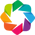

In [1]:
import holoviews as hv
import holoviews.util
hv.extension('bokeh')
#hv.extension('matplotlib')

import numpy as np
import yt
import pandas as pd
import datashader as dshade
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datashader as dshader
import trident
import cPickle

from radial_data_nozeros import *
from astropy.table import Table
from holoviews.operation.datashader import aggregate, datashade, dynspread, shade
from holoviews.operation import decimate
from holoviews.operation import histogram

### Useful Functions for Later

In [2]:
def sym_refine_box(ds,halo_center):
    dx = ds.arr(20.,'kpc').in_units('code_length').value
    dy = ds.arr(50.,'kpc').in_units('code_length').value
    box_left  = [halo_center[0]-dx, halo_center[1]-dy, halo_center[2]-dx]
    box_right = [halo_center[0]+dx, halo_center[1]+dy, halo_center[2]+dx]
    refine_box = ds.r[box_left[0]:box_right[0],
                      box_left[1]:box_right[1],
                      box_left[2]:box_right[2]]
    return refine_box

def get_halo_center(ds, center_guess):
    proper_box_size = ds.get_parameter('CosmologyComovingBoxSize') / ds.get_parameter('CosmologyHubbleConstantNow') * 1000. # in kpc
    ad = ds.sphere(center_guess, (200., 'kpc'))
    x,y,z = np.array(ad["x"]), np.array(ad["y"]), np.array(ad["z"])
    dm_density =  ad['Dark_Matter_Density']
    imax = (np.where(dm_density > 0.9999 * np.max(dm_density)))[0]
    halo_center = [x[imax[0]], y[imax[0]], z[imax[0]]]
    #print 'We have located the main halo at :', halo_center
    return halo_center

def initial_center_guess(ds,track_name):
    track = Table.read(track_name, format='ascii')
    track.sort('col1')
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    centerx = np.interp(zsnap, track['col1'], track['col2'])
    centery = np.interp(zsnap, track['col1'], track['col3'])
    centerz = 0.5 * ( np.interp(zsnap, track['col1'], track['col4']) + 
                      np.interp(zsnap, track['col1'], track['col7']))
    center = [centerx, centery+20. / 143886., centerz]
    return center

### Loading the Data
    This is going to be the annoying part to generalize

In [3]:
ds_name = '/Users/dalek/data/Jason/symmetric_box_tracking/nref11f_sym50kpc/DD0165/DD0165'
ds = yt.load(ds_name)
track_name = '/Users/dalek/data/Jason/symmetric_box_tracking/nref11f_sym50kpc/complete_track_symmetric_100kpc'
center_guess = initial_center_guess(ds,track_name)
halo_center = get_halo_center(ds,center_guess)
rb = sym_refine_box(ds,halo_center)

## also pulling in a non-equal natural refinement output
ds_name = '/Users/dalek/data/Jason/symmetric_box_tracking/nref10f_sym50kpc/DD0165/DD0165'
ds2 = yt.load(ds_name)
track_name = '/Users/dalek/data/Jason/symmetric_box_tracking/nref11f_sym50kpc/complete_track_symmetric_100kpc'
center_guess2 = initial_center_guess(ds2,track_name)
halo_center2 = get_halo_center(ds2,center_guess2)
halo_center2 = get_halo_center(ds2,halo_center2)
rb2 = sym_refine_box(ds2,halo_center2)

## also pulling in a non-equal natural refinement output
#ds_name = '/Users/dalek/data/Jason/natural/nref11/RD0038/RD0038'
#ds2 = yt.load(ds_name)
#track_name = '/Users/dalek/data/Jason/symmetric_box_tracking/nref11f_sym50kpc/complete_track_symmetric_100kpc'
#center_guess2 = initial_center_guess(ds2,track_name)
#halo_center2 = get_halo_center(ds2,center_guess2)
#halo_center2 = get_halo_center(ds2,halo_center2)
#rb2 = sym_refine_box(ds2,halo_center2)



yt : [INFO     ] 2017-09-28 22:41:36,373 Parameters: current_time              = 384.816562811
yt : [INFO     ] 2017-09-28 22:41:36,374 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-09-28 22:41:36,376 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-09-28 22:41:36,377 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-09-28 22:41:36,379 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-09-28 22:41:36,380 Parameters: current_redshift          = 0.553814621435
yt : [INFO     ] 2017-09-28 22:41:36,381 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-09-28 22:41:36,382 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-09-28 22:41:36,384 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 3237/3237 [00:00<00:00, 12896.26it/s]
yt : [INFO     ] 2017-09-28 22:41:36,837 Gathering a field list (this may take a moment.)
yt : [INFO     

### Phase Diagram

In [6]:
%%output size=150 filename='phase_test' #fig='png'
%%opts Histogram (alpha=0.3, fill_color='k')

phase_data = np.zeros((len(rb['H_nuclei_density']),2))
phase_data[:,0] = np.log10(rb['H_nuclei_density'])
phase_data[:,1] = np.log10(rb['Temperature'])

phase_data2 = np.zeros((len(rb2['H_nuclei_density']),2))
phase_data2[:,0] = np.log10(rb2['H_nuclei_density'])
phase_data2[:,1] = np.log10(rb2['Temperature'])

points1 = hv.Points(phase_data,kdims=['nH','temp'],label='nref 11')
points2 = hv.Points(phase_data2,kdims=['nH','temp'],label='nref 10')

xhist = (histogram(points1, bin_range=(-6, 1), dimension='nH',normed=True))
yhist = (histogram(points1, bin_range=(3, 8), dimension='temp',normed=True))
xhist2 = (histogram(points2, bin_range=(-6, 1), dimension='nH',normed=True))
yhist2 = (histogram(points2, bin_range=(3, 8), dimension='temp',normed=True))

plot1 = (datashade(points1,cmap=cm.plasma) ) << yhist(plot=dict(width=125)) << xhist(plot=dict(height=125))
plot2 = (datashade(points2,cmap=cm.plasma) )<< yhist2(plot=dict(width=125))<< xhist2(plot=dict(height=125))
plot1 + plot2

:Layout
   .AdjointLayout.I  :AdjointLayout
      :Histogram   [nH]   (Frequency)
      :DynamicMap   []
      :Histogram   [temp]   (Frequency)
   .AdjointLayout.II :AdjointLayout
      :Histogram   [nH]   (Frequency)
      :DynamicMap   []
      :Histogram   [temp]   (Frequency)

### Looking at Dens / Temp Profiles

In [7]:
## Let's start with some basic fields to put into the pandas dataframe
dens = np.log10(rb['H_nuclei_density'])
temp = np.log10(rb['Temperature'])
Zgas = np.log10(rb['metallicity'])
x = rb['x']
y = rb['y']
z = rb['z']

halo_center = ds.arr(halo_center,'code_length')
dist = np.sqrt((halo_center[0]-rb['x'])**2.+(halo_center[1]-rb['y'])**2.+(halo_center[2]-rb['z'])**2.).in_units('kpc')

df = pd.DataFrame({'temp':temp, 'dens':dens, 'Zgas':Zgas,'x':x,'y':y,'z':z,'dist':dist})

## For the natural refinement
## Let's start with some basic fields to put into the pandas dataframe
dens2 = np.log10(rb2['H_nuclei_density'])
temp2 = np.log10(rb2['Temperature'])
Zgas2 = np.log10(rb2['metallicity'])
x2 = rb2['x']
y2 = rb2['y']
z2 = rb2['z']

halo_center2 = ds2.arr(halo_center2,'code_length')
dist2 = np.sqrt((halo_center2[0]-rb2['x'])**2.+(halo_center2[1]-rb2['y'])**2.+(halo_center2[2]-rb2['z'])**2.).in_units('kpc')

df2 = pd.DataFrame({'temp':temp2, 'dens':dens2, 'Zgas':Zgas2,'x':x2,'y':y2,'z':z2,'dist':dist2})

In [8]:
temp_dist = hv.Scatter(df,kdims=['dist'],vdims=['temp'],label="Temperature")
dens_dist = hv.Scatter(df,kdims=['dist'],vdims=['dens'],label='Hydrogen Number Density')
metal_dist = hv.Scatter(df,kdims=['dist'],vdims=['Zgas'],label='Metallicity')
dist_plots = (datashade(temp_dist,cmap=cm.Reds) + datashade(dens_dist,cmap=cm.Blues) + datashade(metal_dist,cmap=cm.BuGn))

temp_dist2 = hv.Scatter(df2,kdims=['dist'],vdims=['temp'],label="Temperature")
dens_dist2 = hv.Scatter(df2,kdims=['dist'],vdims=['dens'],label='Hydrogen Number Density')
metal_dist2 = hv.Scatter(df2,kdims=['dist'],vdims=['Zgas'],label='Metallicity')
dist_plots2 = (datashade(temp_dist2,cmap=cm.Reds) + datashade(dens_dist2,cmap=cm.Blues) + datashade(metal_dist2,cmap=cm.BuGn))

dist_plots_all = dist_plots + dist_plots2

dist_plots_all.cols(3)
##gist_heat,gist_ocean

:Layout
   .DynamicMap.I   :DynamicMap   []
   .DynamicMap.II  :DynamicMap   []
   .DynamicMap.III :DynamicMap   []
   .DynamicMap.IV  :DynamicMap   []
   .DynamicMap.V   :DynamicMap   []
   .DynamicMap.VI  :DynamicMap   []

#### I would also like to be able to color this data categorically. The most obvious for now is by velocity.

In [ ]:
## pulling in some classificaitons from Jason
#categorize by phase 
phase = np.chararray(np.size(dens), 4)
phase[temp < 9.] = 'hot'
phase[temp < 6.] = 'warm'
phase[temp < 5.] = 'cool'
phase[temp < 4.] = 'cold'
phase_color_key = {'hot':'yellow', 'warm':'#4daf4a', 'cool':'#984ea3', 'cold':'salmon'}

#categorize by metallicity 
metal = Zgas
metalcode = np.chararray(np.size(metal), 4)
metalcode[metal < 90.] = 'high'
metalcode[metal < 1.] = 'medi'
metalcode[metal < 0.1] = 'low'
metalcode[metal < 0.01] = 'vlow'
metal_color_key = {'high':'red', 'medi':'green', 'low':'blue', 'vlow':'purple'}

#categorize by velocity
## eventually want to set this up after looking at Melissa's stuff

## Add to the dataframe
df = pd.DataFrame({'temp':temp, 'dens':dens, 'Zgas':Zgas,'x':x,'y':y,'z':z,'dist':dist,
                  'phase':phase,'metalcode':metalcode})
df.phase = df.phase.astype('category')
df.metalcode = df.metalcode.astype('category')


In [ ]:
#temp_dist.aggregate(df['phase'],dshader.count_cat)
#help(hv.Scatter)
temp_dist = hv.Scatter(df,kdims=['dist'],vdims=['temp'],label="Temperature") #,
                      #aggregate=(df['phase'],dshade.count_cat))
datashade(temp_dist)

In [ ]:
gaussspread = dynspread(datashade(hv.NdOverlay(temp_dist, kdims=df['phase']), aggregator=dshade.count_cat('phase')))

In [ ]:
print ds2.current_redshift

print ds.current_redshift